In [6]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

# 1.Data preprocess

## 1.1 Load Data

In [7]:
def load_data(battery):
    mat = loadmat('../datasets/BatteryDataset/' + battery + '.mat') # MAT PATH ESSENTIAL
    counter = 0
    dataset = []
    capacity_data = []
    # print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0])) #total cycle

    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge':
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                                          int(row['time'][0][1]),
                                          int(row['time'][0][2]),
                                          int(row['time'][0][3]),
                                          int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                voltage_measured, current_measured,temperature_measured,
                                current_load, voltage_load, time])

            capacity_data.append([counter + 1, ambient_temperature, date_time, capacity,
                                  voltage_measured, current_measured,temperature_measured,
                                  current_load, voltage_load, time])
            counter = counter + 1
    # print(dataset[0])

    return [pd.DataFrame(data=dataset,
                         columns=['cycle', 'ambient_temperature', 'datetime','capacity',
                                  'voltage_measured','current_measured', 'temperature_measured',
                                  'current_load', 'voltage_load', 'time']),
            pd.DataFrame(data=capacity_data,
                         columns=['cycle', 'ambient_temperature', 'datetime','capacity',
                                  'voltage_measured','current_measured', 'temperature_measured',
                                  'current_load', 'voltage_load', 'time'])]



# dataset, capacity = load_data('B0005')
# capacity.to_csv('../datasets/BatteryCSV/B0005cap.csv', index=False)
# pd.set_option('display.max_columns', 10)
# print(capacity.head(5))
# dataset.describe()



# 2 train

## 2.1 train_dataset process

In [65]:
def norm_data(battery_id):
    dataset, capacity = load_data(battery_id)
    C = capacity['capacity'][0]
    soh = []
    for i in range(len(capacity)):
        soh.append([capacity['capacity'][i] / C])
    soh = pd.DataFrame(data=soh, columns=['SOH'])

    # features for training
    attribs=['voltage_measured', 'current_measured',
             'temperature_measured', 'current_load', 'voltage_load', 'time']
    train_dataset = capacity[attribs]
    sc = MinMaxScaler(feature_range=(0,1)) # = (num-min)/(max-min)
    train_dataset = sc.fit_transform(train_dataset) # issue：not based on Rated
    # print(train_dataset.shape)
    # print(soh.shape)
    attribs_scaled = pd.DataFrame(data=train_dataset,columns=attribs)
    return  pd.concat([capacity['cycle'], attribs_scaled, soh], axis=1)

def data_loader(battery_id,seq_len,input_size):
    dataset = norm_data(battery_id)
    data_set_train=dataset[['cycle','SOH']].values
    x_train=[]
    y_train=[]
    #take the last 10t to predict 10t+1
    for i in range(seq_len,len(data_set_train)):
        x_train.append(data_set_train[i-10:i,1])
        y_train.append(data_set_train[i,1])
    x_train = np.array(x_train)
    x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],input_size)) #(batch,seq_len,input_size)
    return x_train,y_train
# # storge
# dataset_scaled = norm_data('B0005')
# dataset_scaled.to_csv('../datasets/BatteryCSV/B0005norm.csv', index=False)

In [64]:
dataset = norm_data('B0005')
data_set_train=dataset[['cycle','SOH']].values
# data_set_train=data_set_train.iloc[:,1:2].values  # issue2
# dataset=capacity_val['SOH']
# data_train=dataset[(dataset['cycle']<50)]
# data_set_train=data_train.iloc[:,1:2].values
# data_test=dataset[(dataset['cycle']>=50)]
# data_set_test=data_test.iloc[:,1:2].values

# sc=MinMaxScaler(feature_range=(0,1))
# data_set_train=sc.fit_transform(data_set_train)
# data_set_test=sc.transform(data_set_test)
print(data_set_train[2][0])
X_train=[]
y_train=[]
#take the last 10t to predict 10t+1
seq_len = 10
for i in range(seq_len,len(data_set_train)):
    X_train.append(data_set_train[i-10:i,1])
    y_train.append(data_set_train[i,1])

x_train = pd.DataFrame(data=X_train, columns=['SOH','SOH','SOH','SOH','SOH','SOH','SOH','SOH','SOH','SOH'])
print(x_train.shape)
x_train.to_csv('../datasets/BatteryCSV/test.csv', index=False)
y_train = pd.DataFrame(data=y_train, columns=['SOH'])
y_train.to_csv('../datasets/BatteryCSV/test2.csv', index=False)
X_train,y_train=np.array(X_train),np.array(y_train)

X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

print("data_set_train shape: {}".format(data_set_train.shape))
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

3.0
(158, 10)
data_set_train shape: (168, 2)
X_train shape: (158, 10, 1)
y_train shape: (158, 1)


## 2.2 training
class torch.nn.LSTM(*args, **kwargs)
参数有：
    input_size：x的特征维度
    hidden_size：隐藏层的特征维度
    num_layers：lstm隐层的层数，默认为1
    bias：False则bihbih=0和bhhbhh=0. 默认为True
    batch_first：True则输入输出的数据格式为 (batch, seq_len, feature)
    dropout：除最后一层，每一层的输出都进行dropout，默认为: 0
    bidirectional：True则为双向lstm默认为False

LSTM input(seq_len, batch, input_size)
参数有：
    batch：每次喂给网络的数据条数，在NLP中就是一次喂给网络多少个句子 !!!
    seq_len：序列长度，在NLP中就是句子长度，一般都会用pad_sequence补齐长度!!!
    input_size：特征维度，和前面定义网络结构的input_size一致。

output,(ht, ct) = net(input)
    output: 最后一个状态的隐藏层的神经元输出 size = （seq_Len, batch, num_directions * hidden_size)
    ht：最后一个状态的隐含层的状态值
    ct：最后一个状态的隐含层的遗忘门值



In [67]:
# 构建神经网络模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.lstm4 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x) # shape（seq_Len, batch, num_directions * hidden_size)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.lstm4(out)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出作为全连接层的输入
        print(out.shape)
        return out

# 主程序
if __name__ == "__main__":
    # checking if GPU is available
    device = torch.device("cpu")
    if (torch.cuda.is_available()):
        device = torch.device("cuda:0")
        print('Training on GPU.')
    else:
        print('No GPU available, training on CPU.')

    # 构建模型
    input_size = 1
    hidden_size = 64
    num_layers = 1
    output_size = 1
    seq_len = 10   # 预测序列长度
    model = LSTMModel(input_size=input_size,
                      hidden_size=hidden_size,
                      output_size=output_size,
                      num_layers = num_layers)

    # dataset
    # train_data = norm_data('B0005')
    # train_soh = train_data['SOH'].values
    # train_data = torch.tensor(train_soh, dtype=torch.float32).view(-1, seq_len, input_size) # (batch,seq,input)需要填充!
    # train_data_loss =torch.tensor(train_soh, dtype=torch.float32).view(-1, seq_len, input_size)
    # #vailidation
    # validation_data = norm_data('B0006')
    # validation_soh = validation_data['SOH'].values
    # validation_data = torch.tensor(validation_soh, dtype=torch.float32).view(-1, seq_len, input_size)

    # dataset
    train_data, train_data_real = data_loader('B0005',seq_len,input_size)
    # issue3:sourceTensor.clone().detach().requires_grad_(True)
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_data_real = torch.tensor(train_data_real, dtype=torch.float32)
    #vailidation
    validation_data, validation_data_real = data_loader('B0006',seq_len,input_size)
    validation_data = torch.tensor(validation_data, dtype=torch.float32)
    validation_data_real = torch.tensor(validation_data_real, dtype=torch.float32)
    # 定义损失函数和优化器
    epoch = 500
    learning_rate = 0.001
    criterion = nn.MSELoss()
    # criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 储存路径
    work_dir = './LSTM'
    # 添加tensorboard
    writer = SummaryWriter("{}/logs".format(work_dir))

    # device = torch.device("cuda:0")
    # model = model.to(device)
    # criterion = criterion.to(device)

    # 训练模型
    for epoch in range(epoch):
        print("-------epoch  {} -------".format(epoch+1))
        # 训练步骤
        model.train()

        output = model(train_data)
        loss = criterion(output, torch.tensor(train_data_real, dtype=torch.float32).view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("train set Loss: {}".format(loss.item()))

        # 测试步骤
        model.eval()
        total_test_loss = 0
        total_accuracy = 0
        with torch.no_grad():#用于在推断或验证阶段，当不需要计算梯度时，以提高效率和减少内存占用
            test_outputs = model(validation_data)
            loss = criterion(test_outputs, torch.tensor(validation_data_real, dtype=torch.float32).view(-1, 1))
            # total_test_loss = total_test_loss + loss.item()
            # accuracy = (outputs.argmax(1) == targets).sum()
            # total_accuracy = total_accuracy + accuracy
        print("test set Loss: {}".format(loss.item()))
    # Save the trained model
    torch.save(model.state_dict(), 'lstm_model.pth')

Training on GPU.
-------epoch  1 -------
torch.Size([158, 1])
train set Loss: 0.5698292255401611
torch.Size([158, 1])
test set Loss: 0.40899986028671265
-------epoch  2 -------
torch.Size([158, 1])
train set Loss: 0.5303826928138733
torch.Size([158, 1])
test set Loss: 0.376352459192276
-------epoch  3 -------
torch.Size([158, 1])
train set Loss: 0.492838591337204
torch.Size([158, 1])
test set Loss: 0.3447836637496948
-------epoch  4 -------
torch.Size([158, 1])
train set Loss: 0.456315815448761
torch.Size([158, 1])
test set Loss: 0.3136473596096039
-------epoch  5 -------
torch.Size([158, 1])
train set Loss: 0.4200495481491089
torch.Size([158, 1])
test set Loss: 0.28233030438423157
-------epoch  6 -------
torch.Size([158, 1])


C:\Users\CC\AppData\Local\Temp\ipykernel_23664\1914657007.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(train_data_real, dtype=torch.float32).view(-1, 1))
C:\Users\CC\AppData\Local\Temp\ipykernel_23664\1914657007.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(test_outputs, torch.tensor(validation_data_real, dtype=torch.float32).view(-1, 1))


train set Loss: 0.38328808546066284
torch.Size([158, 1])
test set Loss: 0.2502237856388092
-------epoch  7 -------
torch.Size([158, 1])
train set Loss: 0.3452482521533966
torch.Size([158, 1])
test set Loss: 0.21674692630767822
-------epoch  8 -------
torch.Size([158, 1])
train set Loss: 0.3051256537437439
torch.Size([158, 1])
test set Loss: 0.18141557276248932
-------epoch  9 -------
torch.Size([158, 1])
train set Loss: 0.2621445059776306
torch.Size([158, 1])
test set Loss: 0.14400383830070496
-------epoch  10 -------
torch.Size([158, 1])
train set Loss: 0.2156926691532135
torch.Size([158, 1])
test set Loss: 0.10489320009946823
-------epoch  11 -------
torch.Size([158, 1])
train set Loss: 0.16563403606414795
torch.Size([158, 1])
test set Loss: 0.06581174582242966
-------epoch  12 -------
torch.Size([158, 1])
train set Loss: 0.11300113797187805
torch.Size([158, 1])
test set Loss: 0.031400665640830994
-------epoch  13 -------
torch.Size([158, 1])
train set Loss: 0.06152578443288803
torch

# 3.eval and plot comparation

In [78]:
test_data,test_data_real = data_loader('B0005',seq_len,input_size)
# test_data = test_data.loc[(test_data['SOH']>=0.9)]
# test_soh = test_data['SOH'].values
input_data = torch.tensor(test_data, dtype=torch.float32)
# load
lstm = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
lstm.load_state_dict(torch.load('lstm_model.pth'))
lstm.eval()
output = lstm(input_data)
print(output.shape)

predicted_soh = pd.DataFrame(data=output.detach().numpy(), columns=['SOH'])
predicted_soh.to_csv('../datasets/BatteryCSV/B0007output.csv', index=False)

torch.Size([158, 1])
torch.Size([158, 1])


Text(0.5, 1.0, 'Discharge B0007')

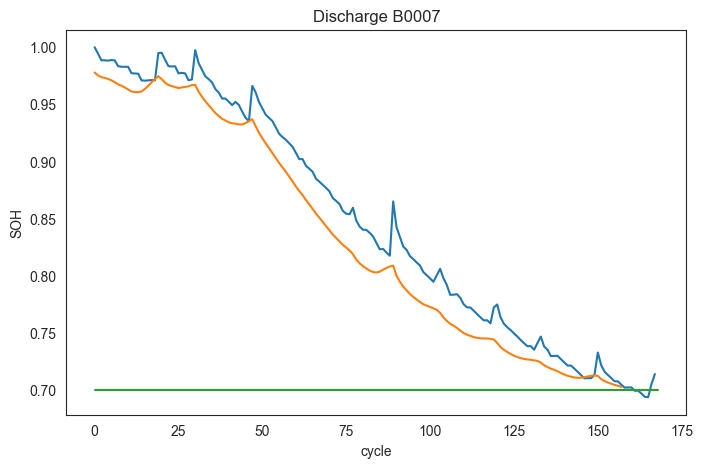

In [79]:
origin_data = norm_data('B0005')
sns.set_style("white")
plt.figure(figsize=(8, 5))
#Draw
plt.plot([i for i in range(len(origin_data['SOH']))], origin_data['SOH'], label='SOH')
plt.plot([i for i in range(len(test_data))], predicted_soh['SOH'], label='Predicted SOH')
plt.plot([0.,len(origin_data['SOH'])], [0.70, 0.70], label='Threshold')

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.ylabel('SOH')
plt.title('Discharge B0007')

In [4]:
import torch.nn as nn
import torch

# 定义一个LSTM模型
lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=1)

# 假设全连接层的输出维度是output_size
output_size = 1
self_fc = nn.Linear(20, output_size)  # 示例中的全连接层

# 输入数据
input_data = torch.randn(5, 3, 10)  # 输入张量的形状为 (seq_len, batch, input_size)

# LSTM前向传播
output, (hn, cn) = lstm(input_data)

# 选择每个序列最后一个时间步的隐藏状态
last_hidden_state = output[-1, :, :]

# 全连接层操作
out = self_fc(last_hidden_state)

# 打印形状
print("output 的形状:", output.shape)
print("last_hidden_state 的形状:", last_hidden_state.shape)
print("out 的形状:", out.shape)

output 的形状: torch.Size([5, 3, 20])
last_hidden_state 的形状: torch.Size([3, 20])
out 的形状: torch.Size([3, 1])
